In [28]:
import os as os
import pandas as pd
import numpy as np
from scipy import stats, integrate
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
import datetime as dt
plt.style.use('seaborn-whitegrid')

plt.rcParams['image.cmap'] = 'blue'

#sns.set_context('notebook',font_scale=2)
sns.set_style("whitegrid")
% matplotlib inline
plt.rcParams['font.size'] = 22
plt.rcParams.update({'figure.figsize': (20,10)})
plt.rcParams.update({'axes.titlesize': 'large'})
plt.rcParams.update({'axes.labelsize': 'large'})
# mpl.rcParams.keys()

In [29]:
!cd data && ls

2014-05 - Citi Bike trip data.csv	  taxi_tree_test_X_20130506-12.csv
bike_20140505_with_dist_and_avg_velo.csv  taxi_tree_test_X.csv
bike_20140505_with_dist.csv		  taxi_tree_test_Xy_20130506-12.csv
bike_20140505_with_dist_velo.csv	  taxi_tree_test_Xy.csv
bike_oneweekfrom20140505.csv		  taxi_tree_test_Xy_sample.csv
data_jan13.csv				  taxi_tree_test_y_20130506-12.csv
README.txt				  taxi_tree_test_y.csv
taxi_oneweekfrom20130107.csv		  yellow_tripdata_2013-05.csv
taxi_oneweekfrom20130506.csv		  yellow_tripdata_2014-05.csv
taxi_oneweekfrom20140505.csv


Use the bash =)

In [30]:
data = pd.read_csv('data/bike_oneweekfrom20140505.csv', index_col=0, parse_dates=True)

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185744 entries, 0 to 185743
Data columns (total 15 columns):
tripduration               185744 non-null int64
starttime                  185744 non-null object
stoptime                   185744 non-null object
start station id           185744 non-null int64
start station name         185744 non-null object
start station latitude     185744 non-null float64
start station longitude    185744 non-null float64
end station id             185744 non-null int64
end station name           185744 non-null object
end station latitude       185744 non-null float64
end station longitude      185744 non-null float64
bikeid                     185744 non-null int64
usertype                   185744 non-null object
birth year                 185744 non-null object
gender                     185744 non-null int64
dtypes: float64(4), int64(5), object(6)
memory usage: 22.7+ MB


So parsing doe not work, do it manually:

In [32]:
data.columns

Index(['tripduration', 'starttime', 'stoptime', 'start station id',
       'start station name', 'start station latitude',
       'start station longitude', 'end station id', 'end station name',
       'end station latitude', 'end station longitude', 'bikeid', 'usertype',
       'birth year', 'gender'],
      dtype='object')

In [33]:
new_column_names = ['trip_time', 'pickup_datetime', 'dropoff_datetime', 'start_station_id',
       'start_station_name', 'pickup_latitude',
       'pickup_longitude', 'end_station_id', 'end_station_name',
       'dropoff_latitude', 'dropoff_longitude', 'bikeid', 'usertype',
       'birth year', 'gender']

In [34]:
data.columns = new_column_names

In [35]:
data.describe()

,trip_time,start_station_id,pickup_latitude,pickup_longitude,end_station_id,dropoff_latitude,dropoff_longitude,bikeid,gender
count,185744.000000,185744.000000,185744.000000,185744.000000,185744.000000,185744.000000,185744.000000,185744.000000,185744.000000
mean,869.523107,450.726511,40.734630,-73.991079,451.404142,40.734387,-73.991147,18157.530305,1.090598
std,974.098663,370.232259,0.019489,0.012186,375.448276,0.019530,0.012298,2119.989210,0.550519
min,60.000000,72.000000,40.680342,-74.017134,72.000000,40.680342,-74.017134,14529.000000,0.000000
25%,401.000000,304.000000,40.721655,-73.999947,303.000000,40.721101,-74.000040,16315.000000,1.000000
50%,640.000000,405.000000,40.736494,-73.990765,404.000000,40.736197,-73.990931,18164.000000,1.000000
75%,1059.000000,490.000000,40.750073,-73.982050,489.000000,40.749718,-73.982050,20005.000000,1.000000
max,21549.000000,3002.000000,40.771522,-73.953809,3002.000000,40.771522,-73.953809,21679.000000,2.000000


In [36]:
data['pickup_datetime'] =pd.to_datetime(data['pickup_datetime'], format = '%Y-%m-%d %H:%M:%S')
data['dropoff_datetime'] =pd.to_datetime(data['dropoff_datetime'], format = '%Y-%m-%d %H:%M:%S')
data['trip_time'] = pd.to_timedelta(data['trip_time'], 's')

In [37]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
trip_time,185744,0 days 00:14:29.523107,0 days 00:16:14.098662,0 days 00:01:00,0 days 00:06:41,0 days 00:10:40,0 days 00:17:39,0 days 05:59:09
start_station_id,185744,450.727,370.232,72,304,405,490,3002
pickup_latitude,185744,40.7346,0.0194894,40.6803,40.7217,40.7365,40.7501,40.7715
pickup_longitude,185744,-73.9911,0.012186,-74.0171,-73.9999,-73.9908,-73.9821,-73.9538
end_station_id,185744,451.404,375.448,72,303,404,489,3002
dropoff_latitude,185744,40.7344,0.0195297,40.6803,40.7211,40.7362,40.7497,40.7715
dropoff_longitude,185744,-73.9911,0.0122976,-74.0171,-74,-73.9909,-73.9821,-73.9538
bikeid,185744,18157.5,2119.99,14529,16315,18164,20005,21679
gender,185744,1.0906,0.550519,0,1,1,1,2


In [38]:
data.head()

,trip_time,pickup_datetime,dropoff_datetime,start_station_id,start_station_name,pickup_latitude,pickup_longitude,end_station_id,end_station_name,dropoff_latitude,dropoff_longitude,bikeid,usertype,birth year,gender
0,00:04:49,2014-05-05 00:00:14,2014-05-05 00:05:03,495,W 47 St & 10 Ave,40.762699,-73.993012,469,Broadway & W 53 St,40.763441,-73.982681,17039,Subscriber,1986,1
1,00:17:31,2014-05-05 00:00:19,2014-05-05 00:17:50,281,Grand Army Plaza & Central Park S,40.764397,-73.973715,236,St Marks Pl & 2 Ave,40.728419,-73.987140,17875,Subscriber,1985,1
2,00:03:57,2014-05-05 00:01:05,2014-05-05 00:05:02,309,Murray St & West St,40.714979,-74.013012,3002,South End Ave & Liberty St,40.711512,-74.015756,18008,Customer,\N,0
3,00:08:54,2014-05-05 00:01:12,2014-05-05 00:10:06,151,Cleveland Pl & Spring St,40.721816,-73.997203,345,W 13 St & 6 Ave,40.736494,-73.997044,18237,Subscriber,1983,1
4,00:04:35,2014-05-05 00:01:16,2014-05-05 00:05:51,173,Broadway & W 49 St,40.760647,-73.984427,449,W 52 St & 9 Ave,40.764618,-73.987895,16607,Subscriber,1985,1


In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185744 entries, 0 to 185743
Data columns (total 15 columns):
trip_time             185744 non-null timedelta64[ns]
pickup_datetime       185744 non-null datetime64[ns]
dropoff_datetime      185744 non-null datetime64[ns]
start_station_id      185744 non-null int64
start_station_name    185744 non-null object
pickup_latitude       185744 non-null float64
pickup_longitude      185744 non-null float64
end_station_id        185744 non-null int64
end_station_name      185744 non-null object
dropoff_latitude      185744 non-null float64
dropoff_longitude     185744 non-null float64
bikeid                185744 non-null int64
usertype              185744 non-null object
birth year            185744 non-null object
gender                185744 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(4), object(4), timedelta64[ns](1)
memory usage: 22.7+ MB


Amount of stations: 326


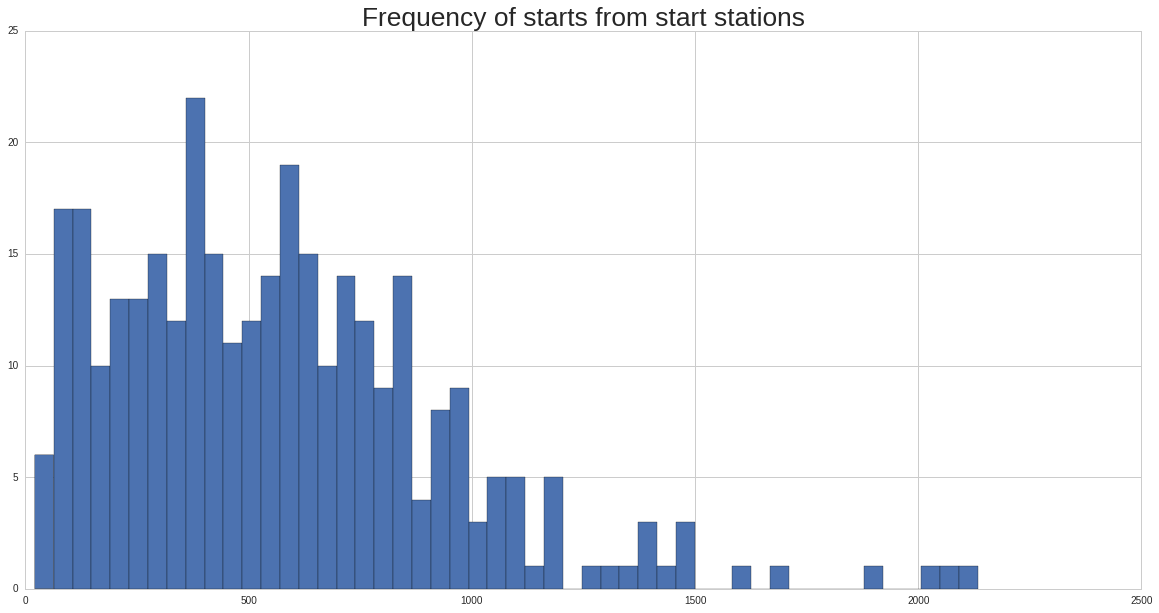

In [40]:
group_by_start = data.groupby(data.start_station_id, )
usage_freq = group_by_start.trip_time.count()
print('Amount of stations: ' + str(len(usage_freq)))
plt.hist(usage_freq, bins = 50)
plt.title('Frequency of starts from start stations')

We are not interested in the following features (they do not add any further information):

# Check for missing and false data:

In [41]:
data.isnull().sum()

trip_time             0
pickup_datetime       0
dropoff_datetime      0
start_station_id      0
start_station_name    0
pickup_latitude       0
pickup_longitude      0
end_station_id        0
end_station_name      0
dropoff_latitude      0
dropoff_longitude     0
bikeid                0
usertype              0
birth year            0
gender                0
dtype: int64

So there is not that much data missing. That's quite surprising, maybe it's wrong.

In [42]:
(data==0).sum()

trip_time                 0
pickup_datetime           0
dropoff_datetime          0
start_station_id          0
start_station_name        0
pickup_latitude           0
pickup_longitude          0
end_station_id            0
end_station_name          0
dropoff_latitude          0
dropoff_longitude         0
bikeid                    0
usertype                  0
birth year                0
gender                20495
dtype: int64

So we only have many zeros in the gender-feature. But gender is a binary variable, therefore a 0 is not equal to NA.

Quick pverview about the trip_times

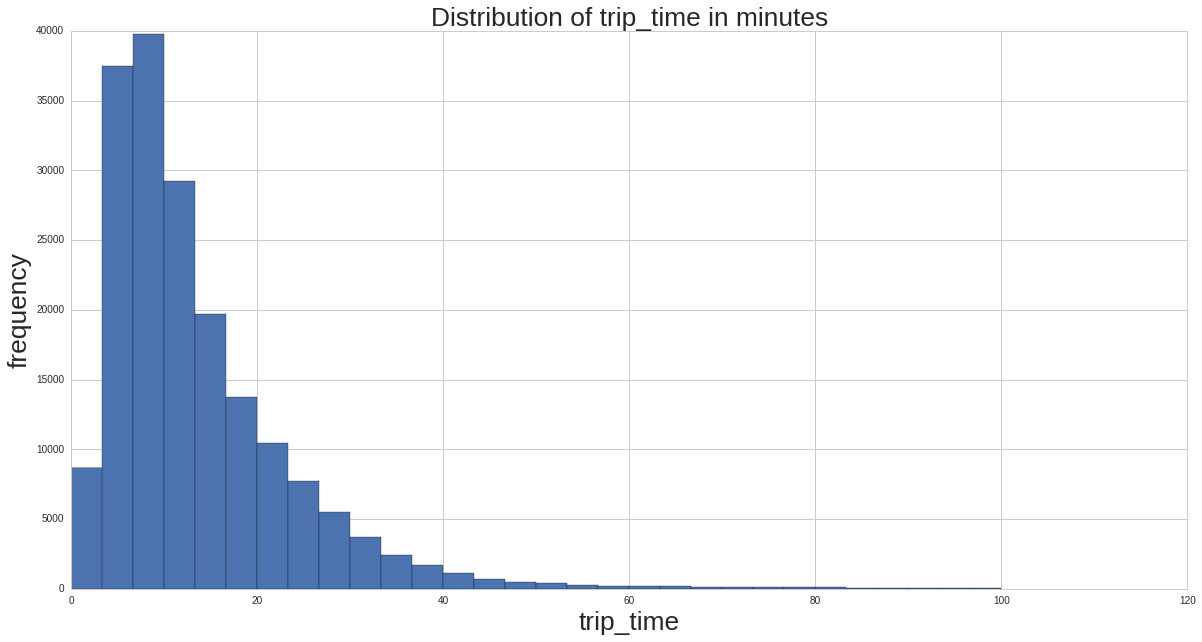

In [43]:
plt.hist((data['trip_time'] / np.timedelta64(1, 'm')), bins=30, range=[0, 100])
plt.title('Distribution of trip_time in minutes')
plt.xlabel('trip_time')
plt.ylabel('frequency')

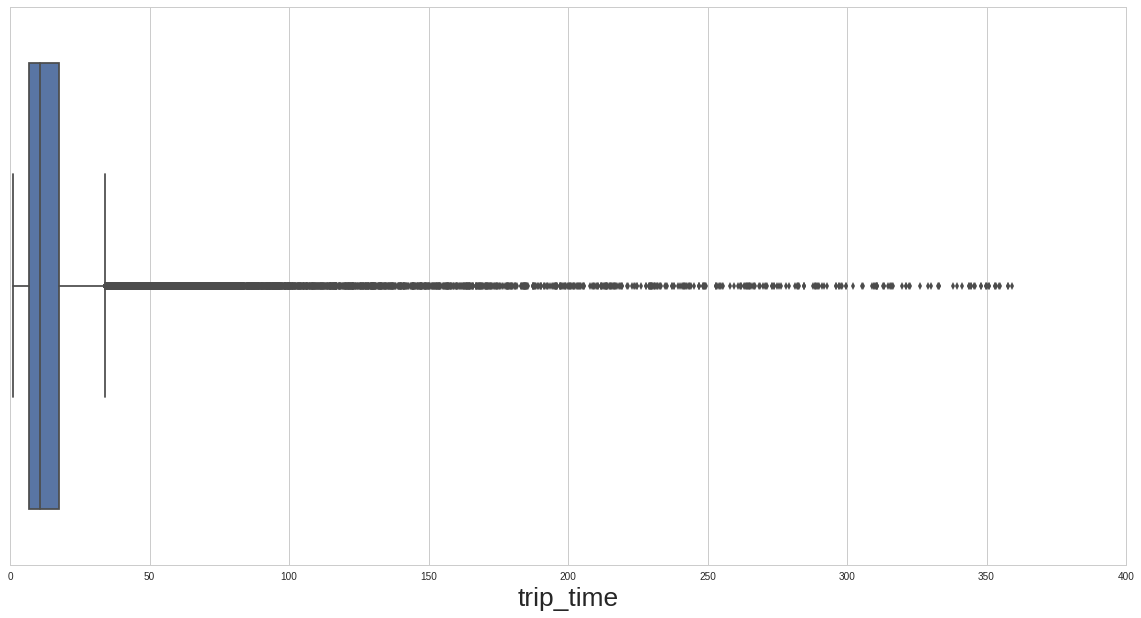

In [44]:
sns.boxplot((data['trip_time'] / np.timedelta64(1, 'm')))

We have lots of outliers.

So as we can see, we have many outliers.

In [45]:
data.trip_time.quantile([0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

0.01          00:01:59
0.05          00:03:25
0.10          00:04:25
0.25          00:06:41
0.50          00:10:40
0.75          00:17:39
0.90          00:26:54
0.95          00:33:56
0.99   01:08:57.570000
Name: trip_time, dtype: timedelta64[ns]

In [46]:
len(data.trip_time.value_counts().values)

5353

Identify the the cases without geo data and remove them from our data to be processed.

In [47]:
anomaly = data.loc[(data['dropoff_longitude'].isnull()) | (data['dropoff_latitude'].isnull()) | 
                       (data['pickup_longitude'].isnull()) | (data['pickup_latitude'].isnull())]
data = data.drop(anomaly.index)

In [48]:
anomaly['flag'] = 'geo_NA'

In [49]:
data.isnull().sum()

trip_time             0
pickup_datetime       0
dropoff_datetime      0
start_station_id      0
start_station_name    0
pickup_latitude       0
pickup_longitude      0
end_station_id        0
end_station_name      0
dropoff_latitude      0
dropoff_longitude     0
bikeid                0
usertype              0
birth year            0
gender                0
dtype: int64

So how many percent of data are left to be processed?

In [50]:
len(data)/(len(data)+len(anomaly))

1.0

In [51]:
anomaly.tail()

,trip_time,pickup_datetime,dropoff_datetime,start_station_id,start_station_name,pickup_latitude,pickup_longitude,end_station_id,end_station_name,dropoff_latitude,dropoff_longitude,bikeid,usertype,birth year,gender,flag


# <font color = 'blue'> So we dropped nothing because of missing geo tags. </font color>

(array([  1886.,  12429.,  23265.,  25474.,  22858.,  18987.,  14736.,
         11772.,   9414.,   7721.,   6635.,   5540.,   4620.,   3809.,
          3101.,   2403.,   1852.,   1427.,   1223.,    958.,    755.,
           558.,    395.,    337.,    307.,    247.,    231.,    180.,
           141.,    134.,    124.,    122.,    134.,     72.,     84.,
            67.,     79.,     63.,     59.,     71.,     61.,     59.,
            42.,     47.,     37.,     37.,     41.,     47.,     38.,
            43.]),
 array([   0.,    2.,    4.,    6.,    8.,   10.,   12.,   14.,   16.,
          18.,   20.,   22.,   24.,   26.,   28.,   30.,   32.,   34.,
          36.,   38.,   40.,   42.,   44.,   46.,   48.,   50.,   52.,
          54.,   56.,   58.,   60.,   62.,   64.,   66.,   68.,   70.,
          72.,   74.,   76.,   78.,   80.,   82.,   84.,   86.,   88.,
          90.,   92.,   94.,   96.,   98.,  100.]),
 <a list of 50 Patch objects>)

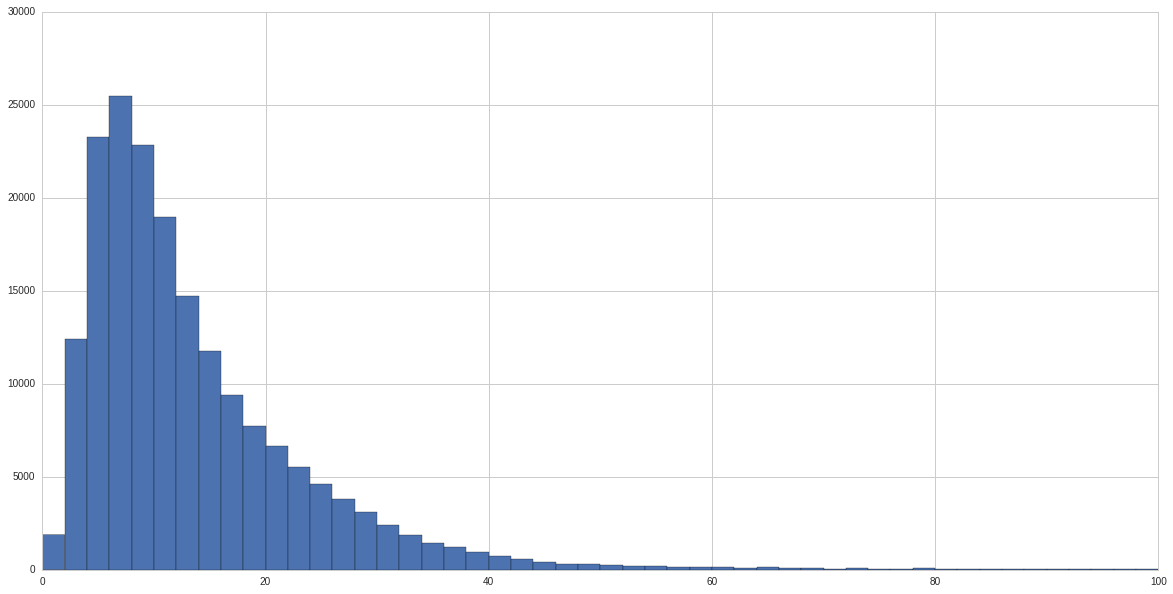

In [52]:
plt.hist(data.trip_time.values / np.timedelta64(1, 'm'), bins=50, range=[0,100])

# We sometimes have some unreasonably small trip_times.

Calculate the distance of a trip. Use the difference of lon / lat data and parse it to metrics.

In [53]:
data['trip_dist'] = -1

In [54]:
# inpout for vincenty:(location.latitude, location.longitude)
from geopy.distance import vincenty
for i in range(0, (len(data)-1)):
    pickup = (data.iloc[i]['pickup_latitude'], data.iloc[i]['pickup_longitude'])
    dropoff = (data.iloc[i]['dropoff_latitude'], data.iloc[i]['dropoff_longitude'])
    data.set_value(i, 'trip_dist', vincenty(pickup,dropoff).meters)

# <font color = 'red'> This operation is way too slow! </font color>

In [55]:
data.trip_dist

0          876
1         4153
2          449
3         1630
4          529
5          760
6         1332
7         2297
8          689
9         1371
10        2358
11         558
12        4488
13        2146
14        2803
15        1291
16         446
17        1721
18        2882
19         674
20         927
21        3635
22        2168
23         887
24         810
25         706
26         810
27        1491
28        1003
29         935
          ... 
185714       0
185715     552
185716    2067
185717    1646
185718     535
185719     722
185720     366
185721     565
185722    1839
185723     809
185724       0
185725    1682
185726    1348
185727    1244
185728     739
185729    1314
185730    1154
185731    1694
185732    1896
185733    1061
185734    1208
185735     919
185736    1187
185737     285
185738     285
185739     831
185740     908
185741    1273
185742     906
185743      -1
Name: trip_dist, dtype: int64

We cannot use miles because vincenty ceils / floors the results

In [56]:
data.columns

Index(['trip_time', 'pickup_datetime', 'dropoff_datetime', 'start_station_id',
       'start_station_name', 'pickup_latitude', 'pickup_longitude',
       'end_station_id', 'end_station_name', 'dropoff_latitude',
       'dropoff_longitude', 'bikeid', 'usertype', 'birth year', 'gender',
       'trip_dist'],
      dtype='object')

Check if new column is present

In [ ]:
data.to_csv('data/bike_20140505_with_dist.csv')

In [57]:
data['avg_velocity'] = data.trip_dist.values/(data.trip_time / (np.timedelta64(1, 'h')))

In [58]:
data.avg_velocity = data.avg_velocity/1000

In [59]:
data.avg_velocity

0         10.912111
1         14.225309
2          6.820253
3         10.988764
4          6.925091
5          8.658228
6         12.787200
7         13.713433
8          9.119118
9          7.466868
10         7.867285
11         9.611483
12        10.785581
13         6.966276
14         9.628626
15        11.199036
16         9.122727
17        11.388971
18        13.963930
19         8.543662
20        13.565854
21        11.061708
22        11.086364
23         5.357718
24         9.112500
25         7.241026
26         9.286624
27         3.029120
28        13.035379
29         9.402235
            ...    
185714     0.000000
185715     4.445638
185716    11.554658
185717     8.417045
185718     8.754545
185719     6.203341
185720    11.870270
185721     6.647059
185722     8.631551
185723     8.321143
185724     0.000000
185725    12.883404
185726    11.637410
185727     8.514068
185728     6.964398
185729    13.751163
185730    12.861920
185731    11.818605
185732    11.376000


Convert avg_velocity from km/h to miles/h. (1km = 0,621371 miles)

In [60]:
data['avg_velocity'] = data.avg_velocity*0.627371

In [ ]:
data.to_csv('data/bike_20140505_with_dist_and_avg_velo.csv')

(array([  8.82000000e+03,   5.37300000e+03,   9.07400000e+03,
          1.76000000e+04,   3.17890000e+04,   4.10960000e+04,
          3.53930000e+04,   2.14280000e+04,   9.90700000e+03,
          3.74000000e+03,   1.16200000e+03,   2.77000000e+02,
          6.50000000e+01,   9.00000000e+00,   4.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00]),
 array([ -6.58465190e-03,   9.60503172e-01,   1.92759100e+00,
          2.89467882e+00,   3.86176664e+00,   4.82885447e+00,
          5.79594229e+00,   6.76303011e+00,   7.73011794e+00,
          8.69720576e+00,   9.66429359e+00,   1.06313814e+01,
          1.15984692e+01,   1.25655571e+01,   1.35326449e+01,
          1.44997327e+01,   1.54668205e+01,   1.64339084e+01,
      

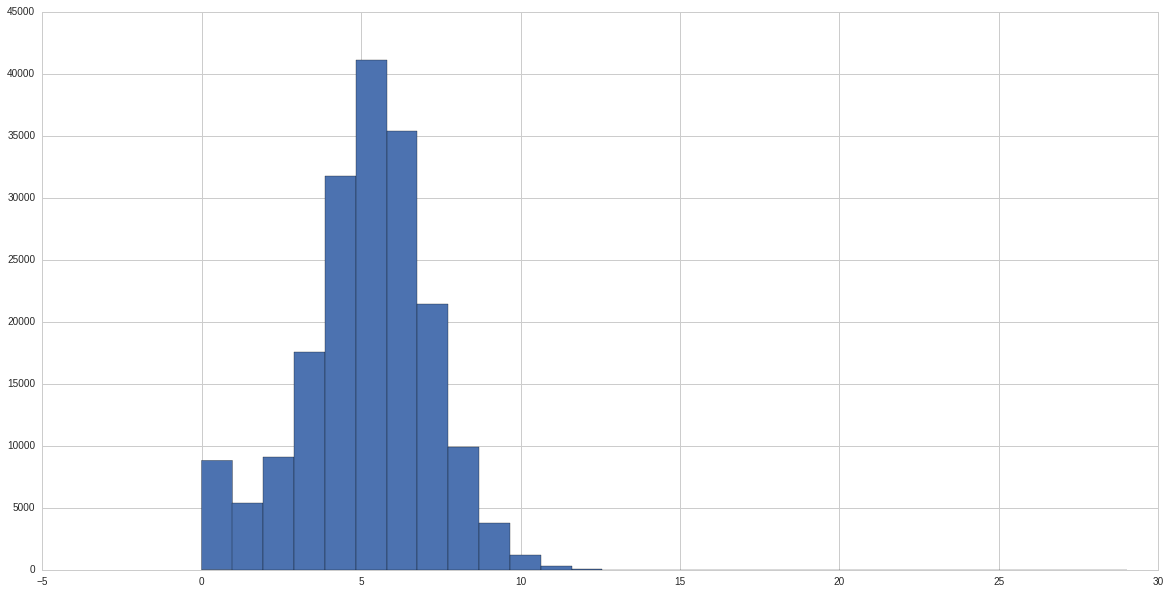

In [61]:
plt.hist(data.avg_velocity, bins=30)

In [62]:
data.avg_velocity.describe() # in mph

count    185744.000000
mean          5.149069
std           2.023218
min          -0.006585
25%           4.068203
50%           5.306131
75%           6.457503
max          29.006050
Name: avg_velocity, dtype: float64

In [63]:
data.head()

,trip_time,pickup_datetime,dropoff_datetime,start_station_id,start_station_name,pickup_latitude,pickup_longitude,end_station_id,end_station_name,dropoff_latitude,dropoff_longitude,bikeid,usertype,birth year,gender,trip_dist,avg_velocity
0,00:04:49,2014-05-05 00:00:14,2014-05-05 00:05:03,495,W 47 St & 10 Ave,40.762699,-73.993012,469,Broadway & W 53 St,40.763441,-73.982681,17039,Subscriber,1986,1,876,6.845942
1,00:17:31,2014-05-05 00:00:19,2014-05-05 00:17:50,281,Grand Army Plaza & Central Park S,40.764397,-73.973715,236,St Marks Pl & 2 Ave,40.728419,-73.987140,17875,Subscriber,1985,1,4153,8.924546
2,00:03:57,2014-05-05 00:01:05,2014-05-05 00:05:02,309,Murray St & West St,40.714979,-74.013012,3002,South End Ave & Liberty St,40.711512,-74.015756,18008,Customer,\N,0,449,4.278829
3,00:08:54,2014-05-05 00:01:12,2014-05-05 00:10:06,151,Cleveland Pl & Spring St,40.721816,-73.997203,345,W 13 St & 6 Ave,40.736494,-73.997044,18237,Subscriber,1983,1,1630,6.894032
4,00:04:35,2014-05-05 00:01:16,2014-05-05 00:05:51,173,Broadway & W 49 St,40.760647,-73.984427,449,W 52 St & 9 Ave,40.764618,-73.987895,16607,Subscriber,1985,1,529,4.344601


In [64]:
data.avg_velocity.quantile([.0001,.01, .5, .75, .95, .975, .99, .995])

0.0001     0.000000
0.0100     0.000000
0.5000     5.306131
0.7500     6.457503
0.9500     8.198881
0.9750     8.802942
0.9900     9.514220
0.9950    10.012335
Name: avg_velocity, dtype: float64

# Be aware: We calculated the avg_velocity based on the euclidean distance. A real driver would never drive that fast. We take all avg_velos >= 5mph (approx. >5%-quantile) into account. We use an upper bound, too. It might not be possible to drive "too fast". If someone drives too fast, the technology has had a malfunction.

In [67]:
lb = 5
ub = 15
anomaly = data.loc[(data['avg_velocity'] < lb) | (data['avg_velocity'] > ub)] # be careful! Maybe adjust to append.
#anomaly.loc[
anomaly.loc[data.loc[(data['avg_velocity'] < lb)].index,'flag'] = 'too_slow'
anomaly.loc[data.loc[(data['avg_velocity'] > ub)].index,'flag'] = 'too_fast'
data = data.drop(anomaly.index, errors='ignore') # ignore uncontained labels / indices
print(1-len(data)/(len(data)+len(anomaly)))

0.42908519252304245


/home/niklas/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/niklas/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


# We dropped about 42% of the data!!

In [68]:
data.avg_velocity.describe()

count    106044.000000
mean          6.502750
std           1.133101
min           5.000057
25%           5.616168
50%           6.269582
75%           7.142086
max          14.099118
Name: avg_velocity, dtype: float64

In [69]:
anomaly.tail()

,trip_time,pickup_datetime,dropoff_datetime,start_station_id,start_station_name,pickup_latitude,pickup_longitude,end_station_id,end_station_name,dropoff_latitude,dropoff_longitude,bikeid,usertype,birth year,gender,trip_dist,avg_velocity,flag
185728,00:06:22,2014-05-11 23:47:22,2014-05-11 23:53:44,308,St James Pl & Oliver St,40.713079,-73.998512,307,Canal St & Rutgers St,40.714275,-73.989900,19916,Subscriber,1983,1,739,4.369261,too_slow
185737,00:03:29,2014-05-11 23:50:54,2014-05-11 23:54:23,526,E 33 St & 5 Ave,40.747659,-73.984907,498,Broadway & W 32 St,40.748549,-73.988084,16197,Customer,\N,0,285,3.079821,too_slow
185738,00:03:09,2014-05-11 23:51:22,2014-05-11 23:54:31,526,E 33 St & 5 Ave,40.747659,-73.984907,498,Broadway & W 32 St,40.748549,-73.988084,14714,Customer,\N,0,285,3.405728,too_slow
185739,00:06:44,2014-05-11 23:52:29,2014-05-11 23:59:13,369,Washington Pl & 6 Ave,40.732241,-74.000264,293,Lafayette St & E 8 St,40.730287,-73.990765,14617,Subscriber,1962,1,831,4.645651,too_slow
185743,00:05:43,2014-05-11 23:53:44,2014-05-11 23:59:27,439,E 4 St & 2 Ave,40.726281,-73.989780,393,E 5 St & Avenue C,40.722992,-73.979955,15825,Customer,\N,0,-1,-0.006585,too_slow


# A little drawing

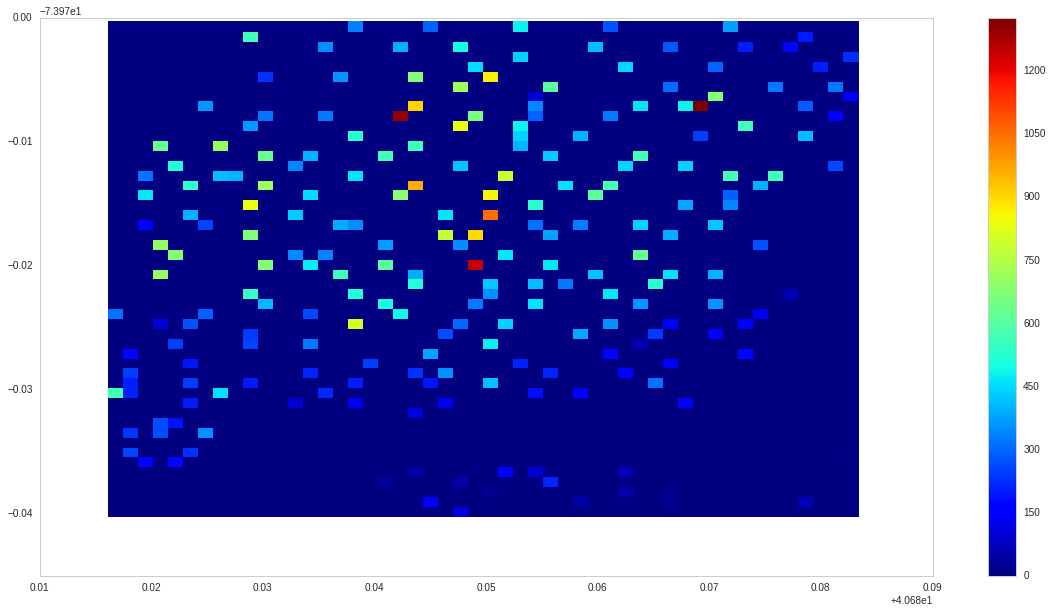

In [70]:
x = data.pickup_latitude
y = data.pickup_longitude

H, xedges, yedges = np.histogram2d(x, y, bins=50, range=[ [x.quantile(.05), x.quantile(.95)], 
        [y.quantile(.05), y.quantile(.95)]], normed=False, weights=None)

plt.jet()
fig = plt.figure(figsize=(20, 10))
#ax.set_title('pcolormesh: exact bin edges')
X, Y = np.meshgrid(xedges, yedges)
mesh = plt.pcolormesh(X, Y, H)
plt.colorbar(mesh)
#ax.set_aspect('equal')
#plt.savefig('figure.pdf', format='pdf')
#plt.savefig('figure.png', format='png')

In [71]:
type(H)

numpy.ndarray

In [72]:
print(H.shape)
print(H.size)
print(H.max())

(50, 50)
2500
1326.0


In [73]:
print(xedges.shape)
xedges[0]

(51,)


40.696192000000003

In [74]:
print(xedges)
print(yedges)

[ 40.696192    40.69753644  40.69888087  40.70022531  40.70156974
  40.70291418  40.70425861  40.70560305  40.70694749  40.70829192
  40.70963636  40.71098079  40.71232523  40.71366967  40.7150141
  40.71635854  40.71770297  40.71904741  40.72039184  40.72173628
  40.72308072  40.72442515  40.72576959  40.72711402  40.72845846
  40.7298029   40.73114733  40.73249177  40.7338362   40.73518064
  40.73652507  40.73786951  40.73921395  40.74055838  40.74190282
  40.74324725  40.74459169  40.74593612  40.74728056  40.748625
  40.74996943  40.75131387  40.7526583   40.75400274  40.75534718
  40.75669161  40.75803605  40.75938048  40.76072492  40.76206935
  40.76341379]
[-74.01020234 -74.0094048  -74.00860725 -74.00780971 -74.00701217
 -74.00621462 -74.00541708 -74.00461954 -74.00382199 -74.00302445
 -74.00222691 -74.00142936 -74.00063182 -73.99983428 -73.99903673
 -73.99823919 -73.99744165 -73.9966441  -73.99584656 -73.99504902
 -73.99425147 -73.99345393 -73.99265639 -73.99185884 -73.9910613

In [75]:
from geopy.distance import vincenty
newport_ri = (41.49008, -71.312796)
cleveland_oh = (41.499498, -81.695391)
print(vincenty(newport_ri, cleveland_oh).kilometers)
#538.3904451566326

866.4554329011002


In [76]:
print('Current bin width:')
print(vincenty((xedges[0], yedges[0]), (xedges[1], yedges[1])).meters)

Current bin width:
163.80909263348332


In [77]:
distances = (-1)*np.ones(len(xedges)-1)
for x in range(0,len(xedges)-1, 1):
    distances[x] = vincenty((xedges[x], yedges[x]), (xedges[x+1], yedges[x+1])).meters

In [78]:
print('Sizes of all bins in meters:')
distances

Sizes of all bins in meters:


array([ 163.80909263,  163.8085668 ,  163.80804096,  163.80751511,
        163.80698926,  163.8064634 ,  163.80593754,  163.80541167,
        163.80488579,  163.80435991,  163.80383403,  163.80330814,
        163.80278224,  163.80225634,  163.80173043,  163.80120452,
        163.8006786 ,  163.80015267,  163.79962674,  163.79910081,
        163.79857486,  163.79804892,  163.79752296,  163.79699701,
        163.79647104,  163.79594507,  163.7954191 ,  163.79489312,
        163.79436713,  163.79384114,  163.79331514,  163.79278914,
        163.79226313,  163.79173712,  163.7912111 ,  163.79068508,
        163.79015905,  163.78963301,  163.78910697,  163.78858092,
        163.78805487,  163.78752881,  163.78700275,  163.78647668,
        163.78595061,  163.78542453,  163.78489844,  163.78437235,
        163.78384625,  163.78332015])

In [79]:
print(str(max(data.pickup_latitude)) +','+ str(max(data.pickup_longitude)))
print(str(max(data.dropoff_latitude)) +','+ str(max(data.dropoff_longitude)))

40.771522,-73.95380904
40.771522,-73.95380904


# Only look at trips in a given bounding box


In [80]:
jfk_geodata = (40.641547, -73.778118)
ridgefield_geodata = (40.856406, -74.020642)
data_in_box = data.loc[(data['dropoff_latitude'] > jfk_geodata[0]) & 
                       (data['dropoff_longitude'] < jfk_geodata[1]) &
                       (data['dropoff_latitude'] < ridgefield_geodata[0]) & 
                       (data['dropoff_longitude'] > ridgefield_geodata[1]) & 
                       (data['pickup_latitude'] > jfk_geodata[0]) & 
                       (data['pickup_longitude'] < jfk_geodata[1]) &
                       (data['pickup_latitude'] < ridgefield_geodata[0]) & 
                       (data['pickup_longitude'] > ridgefield_geodata[1])         
                       ]
# taxidata = taxidata.drop(anomaly.index)

In [81]:
len(data_in_box)/len(data)

1.0

# We lost nothing through the bounding box.

<font color = 'red'> Be careful! They use negative (lat, long), not East/West! </font color>

In [82]:
data_in_box.head()

,trip_time,pickup_datetime,dropoff_datetime,start_station_id,start_station_name,pickup_latitude,pickup_longitude,end_station_id,end_station_name,dropoff_latitude,dropoff_longitude,bikeid,usertype,birth year,gender,trip_dist,avg_velocity
0,00:04:49,2014-05-05 00:00:14,2014-05-05 00:05:03,495,W 47 St & 10 Ave,40.762699,-73.993012,469,Broadway & W 53 St,40.763441,-73.982681,17039,Subscriber,1986,1,876,6.845942
1,00:17:31,2014-05-05 00:00:19,2014-05-05 00:17:50,281,Grand Army Plaza & Central Park S,40.764397,-73.973715,236,St Marks Pl & 2 Ave,40.728419,-73.987140,17875,Subscriber,1985,1,4153,8.924546
3,00:08:54,2014-05-05 00:01:12,2014-05-05 00:10:06,151,Cleveland Pl & Spring St,40.721816,-73.997203,345,W 13 St & 6 Ave,40.736494,-73.997044,18237,Subscriber,1983,1,1630,6.894032
5,00:05:16,2014-05-05 00:01:22,2014-05-05 00:06:38,294,Washington Square E,40.730494,-73.995721,237,E 11 St & 2 Ave,40.730473,-73.986724,15545,Subscriber,1983,2,760,5.431921
6,00:06:15,2014-05-05 00:01:48,2014-05-05 00:08:03,346,Bank St & Hudson St,40.736529,-74.006180,375,Mercer St & Bleecker St,40.726795,-73.996951,18794,Subscriber,1973,1,1332,8.022318


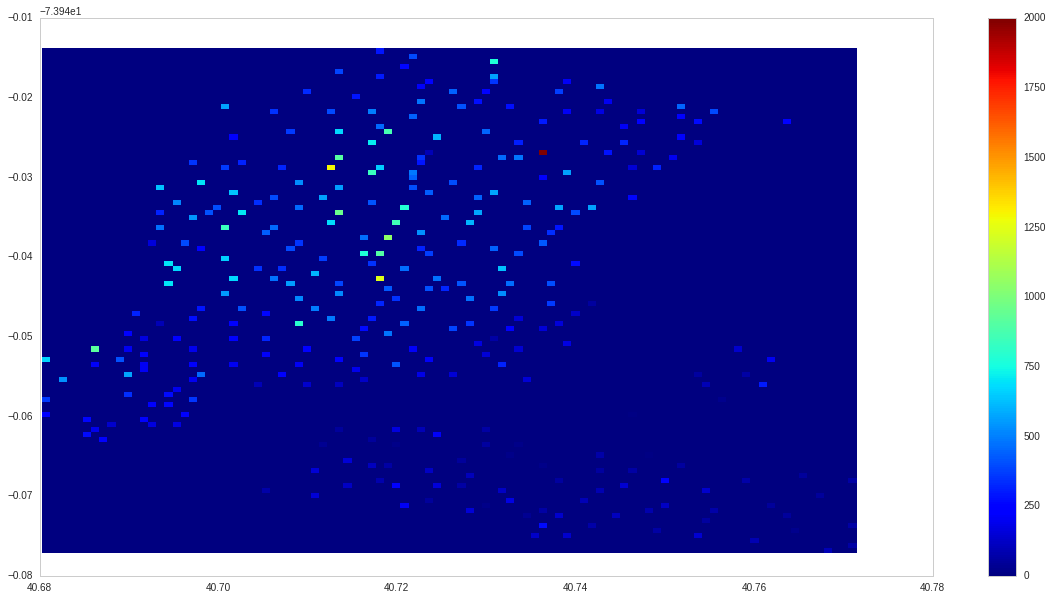

In [83]:
x = data_in_box.pickup_latitude
y = data_in_box.pickup_longitude

H, xedges, yedges = np.histogram2d(x, y, bins=100, normed=False, weights=None)

plt.jet()
fig = plt.figure(figsize=(20, 10))
#ax.set_title('pcolormesh: exact bin edges')
X, Y = np.meshgrid(xedges, yedges)
mesh = plt.pcolormesh(X, Y, H)
plt.colorbar(mesh)
#ax.set_aspect('equal')
#plt.savefig('figure.pdf', format='pdf')
#plt.savefig('figure.png', format='png')

In [84]:
print(H.shape)
print(H.size)
print(H.max())
print(xedges.shape)
print(xedges)
print(yedges)

distances = (-1)*np.ones(len(xedges)-1)
for x in range(0,len(xedges)-1, 1):
    distances[x] = vincenty((xedges[x], yedges[x]), (xedges[x+1], yedges[x+1])).meters
    
print('Sizes of all bins in meters:')
distances

(100, 100)
10000
2001.0
(101,)
[ 40.68034242  40.68125422  40.68216601  40.68307781  40.68398961
  40.6849014   40.6858132   40.68672499  40.68763679  40.68854858
  40.68946038  40.69037218  40.69128397  40.69219577  40.69310756
  40.69401936  40.69493116  40.69584295  40.69675475  40.69766654
  40.69857834  40.69949013  40.70040193  40.70131373  40.70222552
  40.70313732  40.70404911  40.70496091  40.7058727   40.7067845
  40.7076963   40.70860809  40.70951989  40.71043168  40.71134348
  40.71225527  40.71316707  40.71407887  40.71499066  40.71590246
  40.71681425  40.71772605  40.71863785  40.71954964  40.72046144
  40.72137323  40.72228503  40.72319682  40.72410862  40.72502042
  40.72593221  40.72684401  40.7277558   40.7286676   40.72957939
  40.73049119  40.73140299  40.73231478  40.73322658  40.73413837
  40.73505017  40.73596196  40.73687376  40.73778556  40.73869735
  40.73960915  40.74052094  40.74143274  40.74234454  40.74325633
  40.74416813  40.74507992  40.74599172  40.74

array([ 114.53451502,  114.53418823,  114.53386145,  114.53353466,
        114.53320787,  114.53288107,  114.53255428,  114.53222747,
        114.53190067,  114.53157387,  114.53124706,  114.53092025,
        114.53059344,  114.53026662,  114.52993981,  114.52961299,
        114.52928617,  114.52895934,  114.52863251,  114.52830568,
        114.52797885,  114.52765201,  114.52732518,  114.52699834,
        114.52667149,  114.52634465,  114.5260178 ,  114.52569095,
        114.52536409,  114.52503724,  114.52471038,  114.52438352,
        114.52405666,  114.52372979,  114.52340292,  114.52307605,
        114.52274918,  114.5224223 ,  114.52209542,  114.52176854,
        114.52144165,  114.52111477,  114.52078788,  114.52046099,
        114.52013409,  114.51980719,  114.5194803 ,  114.51915339,
        114.51882649,  114.51849958,  114.51817267,  114.51784576,
        114.51751884,  114.51719193,  114.51686501,  114.51653808,
        114.51621116,  114.51588423,  114.5155573 ,  114.51523

In [85]:
(H==0).sum()/H.size

0.96750000000000003

# So we know that about 97% of the bins have 0 pickups in it. This was expected, because we have static stations only.

## Let's take a first look at the distribution if the target variable which we want to estimate:

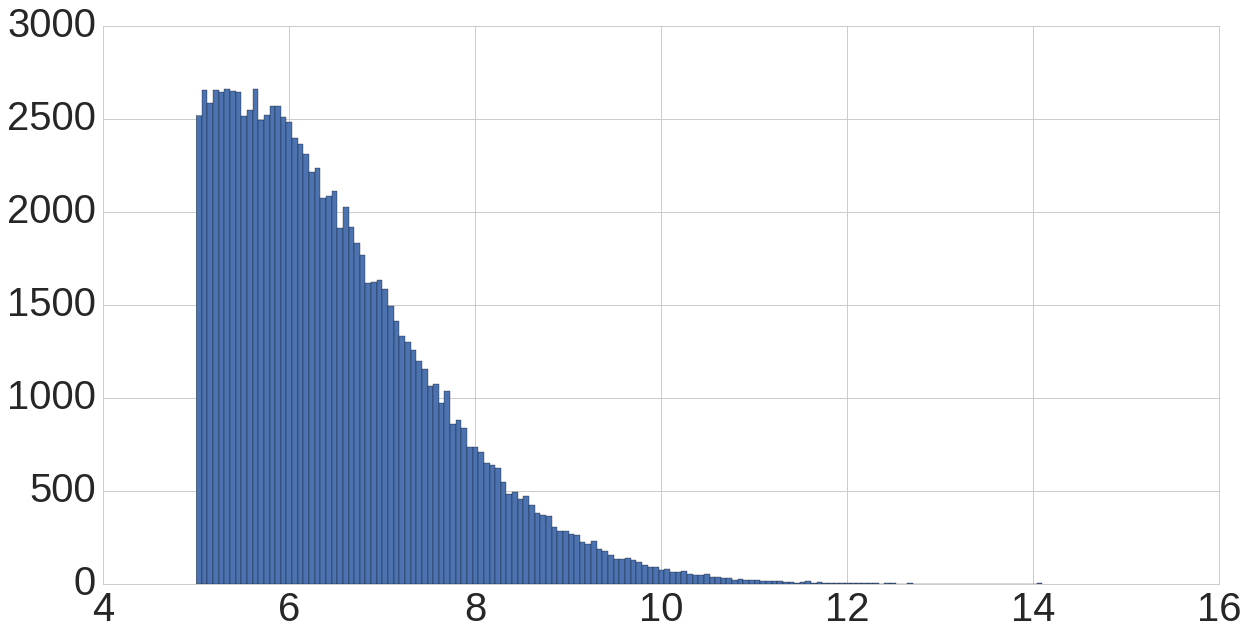

In [86]:
h = data_in_box.avg_velocity.values
plt.figure(figsize=(20,10))
plt.hist(h, normed=False,  bins=150)
    #, histtype='stepfilled')
#plt.yscale('log')
#plt.ylabel('log(freq x)', fontsize=40)
#plt.xlabel('x = avg_amount_per_minute', fontsize=40)
#print('Min:' +  str(min(h)) + '\nMax:' +  str(max(h)))
plt.yticks(fontsize=40)
plt.xticks(fontsize=40)
#plt.locator_params(axis = 'x', nbins = 20)
plt.show()

In [87]:
data_in_box.head()

,trip_time,pickup_datetime,dropoff_datetime,start_station_id,start_station_name,pickup_latitude,pickup_longitude,end_station_id,end_station_name,dropoff_latitude,dropoff_longitude,bikeid,usertype,birth year,gender,trip_dist,avg_velocity
0,00:04:49,2014-05-05 00:00:14,2014-05-05 00:05:03,495,W 47 St & 10 Ave,40.762699,-73.993012,469,Broadway & W 53 St,40.763441,-73.982681,17039,Subscriber,1986,1,876,6.845942
1,00:17:31,2014-05-05 00:00:19,2014-05-05 00:17:50,281,Grand Army Plaza & Central Park S,40.764397,-73.973715,236,St Marks Pl & 2 Ave,40.728419,-73.987140,17875,Subscriber,1985,1,4153,8.924546
3,00:08:54,2014-05-05 00:01:12,2014-05-05 00:10:06,151,Cleveland Pl & Spring St,40.721816,-73.997203,345,W 13 St & 6 Ave,40.736494,-73.997044,18237,Subscriber,1983,1,1630,6.894032
5,00:05:16,2014-05-05 00:01:22,2014-05-05 00:06:38,294,Washington Square E,40.730494,-73.995721,237,E 11 St & 2 Ave,40.730473,-73.986724,15545,Subscriber,1983,2,760,5.431921
6,00:06:15,2014-05-05 00:01:48,2014-05-05 00:08:03,346,Bank St & Hudson St,40.736529,-74.006180,375,Mercer St & Bleecker St,40.726795,-73.996951,18794,Subscriber,1973,1,1332,8.022318


In [88]:
#data_in_box['pickup_datetime'].dt.dayofweek
#tdata_in_box['pickup_datetime'].dt.hourb
#data_in_box['pickup_datetime'].dt.month # year, month, day, hour, minute, second, microsecond, and tzinfo.
#data_in_box['pickup_datetime'].dt.day

# Make a new dataframe with features and targets

In [89]:
time_regression_df = pd.DataFrame([ #data_in_box['pickup_datetime'].dt.day, # leave this out
                          data_in_box['pickup_datetime'].dt.dayofweek,
                          data_in_box['pickup_datetime'].dt.hour,
                          data_in_box['pickup_latitude'],
                          data_in_box['pickup_longitude'],
                          data_in_box['dropoff_latitude'],
                          data_in_box['dropoff_longitude'],
                          np.ceil(data_in_box['avg_velocity'])
                         ]).T

In [90]:
time_regression_df.columns = [#'pickup_datetime_day', 
                              'pickup_datetime_dayofweek', 'pickup_datetime_hour',
                                 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude',
                                 'avg_velocity_mph']

Use minutes for prediction instead of seconds (ceil the time). Definitley more robust than seconds!

In [91]:
time_regression_df.head()

,pickup_datetime_dayofweek,pickup_datetime_hour,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,avg_velocity_mph
0,0.0,0.0,40.762699,-73.993012,40.763441,-73.982681,7.0
1,0.0,0.0,40.764397,-73.973715,40.728419,-73.987140,9.0
3,0.0,0.0,40.721816,-73.997203,40.736494,-73.997044,7.0
5,0.0,0.0,40.730494,-73.995721,40.730473,-73.986724,6.0
6,0.0,0.0,40.736529,-74.006180,40.726795,-73.996951,9.0


In [92]:
time_regression_df.tail()

,pickup_datetime_dayofweek,pickup_datetime_hour,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,avg_velocity_mph
185735,6.0,23.0,40.692395,-73.993379,40.688070,-73.984106,7.0
185736,6.0,23.0,40.707065,-74.007319,40.717488,-74.010455,9.0
185740,6.0,23.0,40.729170,-73.998102,40.721655,-74.002347,11.0
185741,6.0,23.0,40.734232,-73.986923,40.742909,-73.977061,9.0
185742,6.0,23.0,40.726281,-73.989780,40.722992,-73.979955,7.0


In [93]:
time_regression_df.ix[:,0:7].describe()

,pickup_datetime_dayofweek,pickup_datetime_hour,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,avg_velocity_mph
count,106044.000000,106044.000000,106044.000000,106044.000000,106044.000000,106044.000000,106044.000000
mean,2.603636,13.969918,40.735199,-73.990941,40.734848,-73.991118,7.036636
std,1.972009,4.992480,0.019369,0.012164,0.019295,0.012357,1.125662
min,0.000000,0.000000,40.680342,-74.017134,40.680342,-74.017134,6.000000
25%,1.000000,9.000000,40.722174,-73.999733,40.722174,-74.000264,6.000000
50%,2.000000,15.000000,40.737050,-73.990765,40.737050,-73.990931,7.000000
75%,4.000000,18.000000,40.750200,-73.981948,40.749718,-73.982050,8.000000
max,6.000000,23.000000,40.771522,-73.953809,40.771522,-73.953809,15.000000


In [94]:
print(time_regression_df.avg_velocity_mph.value_counts())
print(len(time_regression_df.avg_velocity_mph.value_counts()))

6.0     42576
7.0     33360
8.0     18609
9.0      7849
10.0     2705
11.0      740
12.0      162
13.0       34
14.0        7
15.0        2
Name: avg_velocity_mph, dtype: int64
10


So we hace 87 different times to predict.

As we see, most of the trips take between 2.5 and 35 minutes.

# Split the data into a training dataset and a test dataset. Evaluate the performance of the decision tree on the test data

In [282]:
from sklearn import cross_validation as cv
y = time_regression_df["avg_velocity_mph"]
X = time_regression_df.ix[:,0:6]
X_train, X_test, y_train, y_test = cv.train_test_split(X, y,test_size=0.05,random_state=0) 

# Changed test size to 5%

In [284]:
X_test.head()

,pickup_datetime_dayofweek,pickup_datetime_hour,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
31112,1.0,6.0,40.756014,-73.967416,40.760660,-73.980420
105131,3.0,17.0,40.734927,-73.992005,40.741473,-73.983209
114327,4.0,7.0,40.752416,-73.978370,40.757973,-73.966033
147771,5.0,14.0,40.699869,-73.982719,40.702772,-73.993836
95756,3.0,5.0,40.712690,-73.987763,40.705310,-74.006126


In [285]:
y_test.head()

31112     7.0
105131    6.0
114327    7.0
147771    6.0
95756     7.0
Name: avg_velocity_mph, dtype: float64

In [286]:
Xy_test = pd.concat([X_test, y_test], axis=1)

In [287]:
Xy_test.head()

,pickup_datetime_dayofweek,pickup_datetime_hour,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,avg_velocity_mph
31112,1.0,6.0,40.756014,-73.967416,40.760660,-73.980420,7.0
105131,3.0,17.0,40.734927,-73.992005,40.741473,-73.983209,6.0
114327,4.0,7.0,40.752416,-73.978370,40.757973,-73.966033,7.0
147771,5.0,14.0,40.699869,-73.982719,40.702772,-73.993836,6.0
95756,3.0,5.0,40.712690,-73.987763,40.705310,-74.006126,7.0


In [288]:
#Xy_test.to_csv('taxi_tree_test_Xy_20130506-12.csv')
#X_test.to_csv('taxi_tree_test_X_20130506-12.csv')
#y_test.to_csv('taxi_tree_test_y_20130506-12.csv')
Xy_test.to_csv('bike_tree_test_Xy_20140505-11.csv')
X_test.to_csv('bike_tree_test_X_20140505-11.csv')
y_test.to_csv('bike_tree_test_y_20140506-11.csv')

In [289]:
# Xy_test_sample = Xy_test.sample(10000, random_state=99)

In [290]:
# Xy_test_sample.to_csv('taxi_tree_test_Xy_sample.csv')

In [291]:
# Xy_test_sample.head()

In [292]:
print(X_train.shape)
print(X_train.size)
print(X_test.shape)
print(X.shape)
print(X_train.shape[0]+X_test.shape[0])

(100741, 6)
604446
(5303, 6)
(106044, 6)
106044


In [329]:
import time
t = time.time()

In [330]:
print(__doc__)

# Import the necessary modules and libraries
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import matplotlib.pyplot as plt

#features = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude','pickup_datetime']
#print("* features:", features, sep="\n")


regtree = DecisionTreeRegressor(min_samples_split=3, random_state=99, max_depth=10)# formerly 15. 15 is reasonable
                                                                                     # random states: 99
regtree.fit(X_train, y_train)




Automatically created module for IPython interactive environment


DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=3,
           min_weight_fraction_leaf=0.0, presort=False, random_state=99,
           splitter='best')

In [331]:
elapsed = time.time() - t
print(elapsed)

0.6866641044616699


In [397]:
regtree.score(X_test, y_test)

0.082688699392281406

Perzentile(%):  [1, 5, 10, 15, 25, 50, 75, 90, 95, 99] 
 [-3.15703218 -2.15703218 -1.33019608 -1.15703218 -0.54723708  0.04759036
  0.84296782  1.03210762  1.18947368  1.6025878 ]
Absolute time deviation (in 1k):  4.51398329768


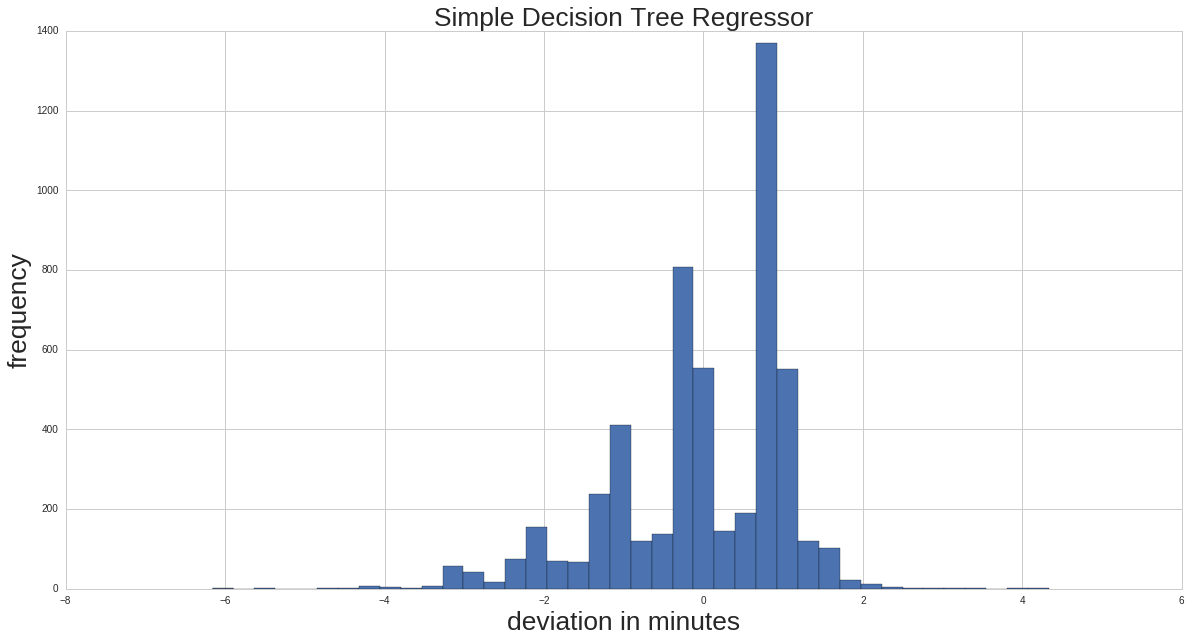

In [398]:
y_pred = regtree.predict(X_test)
np.linalg.norm(np.ceil(y_pred)-y_test)
diff = (y_pred-y_test)
# plt.figure(figsize=(12,10)) # not needed. set values globally
plt.hist(diff.values, bins=40)
print('Perzentile(%): ', [1,5,10,15,25,50,75,90,95,99], '\n', np.percentile(diff.values, [1,5,10,15,25,50,75,90,95,99]))
print('Absolute time deviation (in 1k): ', sum(abs(diff))/1000)
plt.title('Simple Decision Tree Regressor')
plt.xlabel('deviation in minutes')
plt.ylabel('frequency')

In [143]:
time_regression_df.columns[6]

'avg_velocity_mph'

In [399]:
from sklearn import tree
tree.export_graphviz(regtree, out_file='figures/bike_tree_d10.dot', feature_names=time_regression_df.ix[:,0:6].columns, class_names=time_regression_df.columns[6])

In [400]:
print(regtree.tree_.feature)
print(regtree.tree_.children_left)
print(regtree.tree_.children_right)

[ 5  2  4 ...,  0 -2 -2]
[   1    2    3 ..., 1637   -1   -1]
[ 784  399  236 ..., 1638   -1   -1]


Prepare a dictionary to look uop the features that are splitted in the nodes

In [401]:
feature_dict = {}
for i in range(0,7):
    feature_dict[i] = time_regression_df.ix[:,i].name
print(feature_dict)

{0: 'pickup_datetime_dayofweek', 1: 'pickup_datetime_hour', 2: 'pickup_latitude', 3: 'pickup_longitude', 4: 'dropoff_latitude', 5: 'dropoff_longitude', 6: 'avg_velocity_mph'}


In [402]:
feature_splits = list(regtree.tree_.feature)
for i in range(0,len(regtree.tree_.feature)):
    if feature_splits[i] >= 0:
        feature_splits[i] = feature_dict[feature_splits[i]]

In [403]:
print(feature_splits)
print(regtree.tree_.threshold)

['dropoff_longitude', 'pickup_latitude', 'dropoff_latitude', 'pickup_datetime_hour', 'pickup_latitude', 'pickup_latitude', 'dropoff_latitude', 'pickup_datetime_dayofweek', 'pickup_longitude', 'pickup_datetime_hour', -2, -2, 'dropoff_latitude', -2, -2, 'pickup_longitude', 'pickup_latitude', -2, -2, 'pickup_datetime_hour', -2, -2, 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', -2, -2, 'dropoff_latitude', -2, -2, 'dropoff_longitude', 'dropoff_longitude', -2, -2, 'dropoff_latitude', -2, -2, 'dropoff_latitude', 'pickup_longitude', 'dropoff_latitude', 'pickup_datetime_hour', -2, -2, 'dropoff_latitude', -2, -2, 'dropoff_latitude', 'pickup_latitude', -2, -2, 'pickup_latitude', -2, -2, 'pickup_latitude', 'pickup_datetime_dayofweek', -2, 'dropoff_longitude', -2, -2, 'pickup_longitude', 'pickup_datetime_dayofweek', -2, -2, 'pickup_longitude', -2, -2, 'pickup_longitude', 'dropoff_latitude', 'dropoff_latitude', 'pickup_latitude', -2, 'dropoff_latitude', -2, -2, 'pickup_datetime_hour', 

In [404]:
# from http://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree
def get_code(tree, feature_names):
        left      = tree.tree_.children_left
        right     = tree.tree_.children_right
        threshold = tree.tree_.threshold
        features  = [feature_names[i] for i in tree.tree_.feature]
        value = tree.tree_.value

        def recurse(left, right, threshold, features, node):
                if (threshold[node] != -2):
                        print( "if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")
                        if left[node] != -1:
                                recurse (left, right, threshold, features,left[node])
                        print( "} else {")
                        if right[node] != -1:
                                recurse (left, right, threshold, features,right[node])
                        print( "}")
                else:
                        print( "return " + str(value[node]))

        recurse(left, right, threshold, features, 0)

In [405]:
# from http://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree
def get_code_matrix(tree, feature_names):
        decision_list = []
        left      = tree.tree_.children_left
        right     = tree.tree_.children_right
        threshold = tree.tree_.threshold
        features  = [feature_names[i] for i in tree.tree_.feature]
        value = tree.tree_.value
        #frame =  pd.DataFrame(np.nan, columns=['leaf_no', range(1,tree.tree_.max_depth), 'value'])

        def recurse(left, right, threshold, features, node):
                if (threshold[node] != -2):
                        decision_list.append({str(features[node]):threshold[node]})
                        if left[node] != -1:
                                recurse (left, right, threshold, features,left[node])
                        decision_list.append({'back': -1})
                        if right[node] != -1:
                                recurse (left, right, threshold, features,right[node])
                        decision_list.append({'back': -1})
                else:
                        decision_list.append({'leaf_val':value[node][0][0]})

        recurse(left, right, threshold, features, 0) # root node
        return decision_list

In [406]:
a = get_code_matrix(regtree, feature_names=time_regression_df.ix[:,0:7].columns)

In [407]:
a[0:20]

[{'dropoff_longitude': -74.007270812988281},
 {'pickup_latitude': 40.746696472167969},
 {'dropoff_latitude': 40.740638732910156},
 {'pickup_datetime_hour': 7.5},
 {'pickup_latitude': 40.735282897949219},
 {'pickup_latitude': 40.720314025878906},
 {'dropoff_latitude': 40.703102111816406},
 {'pickup_datetime_dayofweek': 1.5},
 {'pickup_longitude': -74.01617431640625},
 {'pickup_datetime_hour': 6.5},
 {'leaf_val': 7.0},
 {'back': -1},
 {'leaf_val': 9.0},
 {'back': -1},
 {'back': -1},
 {'dropoff_latitude': 40.702228546142578},
 {'leaf_val': 6.7000000000000002},
 {'back': -1},
 {'leaf_val': 7.833333333333333},
 {'back': -1}]

In [408]:
len(a)

3277

In [409]:
a[0:20]

[{'dropoff_longitude': -74.007270812988281},
 {'pickup_latitude': 40.746696472167969},
 {'dropoff_latitude': 40.740638732910156},
 {'pickup_datetime_hour': 7.5},
 {'pickup_latitude': 40.735282897949219},
 {'pickup_latitude': 40.720314025878906},
 {'dropoff_latitude': 40.703102111816406},
 {'pickup_datetime_dayofweek': 1.5},
 {'pickup_longitude': -74.01617431640625},
 {'pickup_datetime_hour': 6.5},
 {'leaf_val': 7.0},
 {'back': -1},
 {'leaf_val': 9.0},
 {'back': -1},
 {'back': -1},
 {'dropoff_latitude': 40.702228546142578},
 {'leaf_val': 6.7000000000000002},
 {'back': -1},
 {'leaf_val': 7.833333333333333},
 {'back': -1}]

In [410]:
decisions = np.ndarray(shape=(2**regtree.tree_.max_depth, 2*regtree.tree_.max_depth+2), dtype = '<U30')

In [411]:
m = 0
n = 0
for i in range(0,len(a)):
    if (list(a[i].values()) != [-1]):
        #print(n)
        #print(i)
        #print('if')
        #print(list(a[i].keys()) == ['leaf_val'])
        #print(decisions[m,n])
        decisions[m,2*n] = list(a[i].keys())[0]
        decisions[m,2*n+1] = list(a[i].values())[0]
        n = n+1
        #print(n)
    if (list(a[i].keys()) == ['leaf_val']):
        #print('elif')
        m = m+1
        #print(n)
    elif(list(a[i].values()) == [-1]):
        #print('else')
        n = n-1
    #print(n,m)

In [412]:
decisions

array([['dropoff_longitude', '-74.007270813', 'pickup_latitude', ...,
        '6.5', 'leaf_val', '7.0'],
       ['', '', '', ..., '', 'leaf_val', '9.0'],
       ['', '', '', ..., '40.7022285461', 'leaf_val', '6.7'],
       ..., 
       ['', '', '', ..., '', '', ''],
       ['', '', '', ..., '', '', ''],
       ['', '', '', ..., '', '', '']], 
      dtype='<U30')

In [413]:
#np.savetxt('decisions.txt', decisions, fmt='%s', delimiter=',')

# decisions.nonzero(): Try somehow to replace the 'None'-values with 'same' or something like that

In [414]:
decisions

array([['dropoff_longitude', '-74.007270813', 'pickup_latitude', ...,
        '6.5', 'leaf_val', '7.0'],
       ['', '', '', ..., '', 'leaf_val', '9.0'],
       ['', '', '', ..., '40.7022285461', 'leaf_val', '6.7'],
       ..., 
       ['', '', '', ..., '', '', ''],
       ['', '', '', ..., '', '', ''],
       ['', '', '', ..., '', '', '']], 
      dtype='<U30')

In [392]:
t = time.time()

In [393]:
from sklearn.ensemble import RandomForestRegressor

rd_regtree = RandomForestRegressor(n_estimators=12,n_jobs=6,min_samples_split=3, random_state=99, max_depth=17) 
#total sum of diff: 1132
#rd_regtree = RandomForestRegressor(n_estimators=40,n_jobs=-1,min_samples_split=3, random_state=99, max_depth=11)
#total sum of diff: 1129
rd_regtree.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=17,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           n_estimators=12, n_jobs=6, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

In [394]:
elapsed_rd_regtree = time.time() - t
print(elapsed_rd_regtree)

1.0190808773040771


In [395]:
print(rd_regtree.score(X_test, y_test))

0.173798826508


In [338]:
print(len(X_train))
print(len(X_test))

100741
5303


Perzentile(%):  [1, 5, 10, 15, 25, 50, 75, 90, 95, 99] 
 [-3.15703218 -2.15703218 -1.33019608 -1.15703218 -0.54723708  0.04759036
  0.84296782  1.03210762  1.18947368  1.6025878 ]
Mean absolute velocity deviation (in 1k):  0.851213143066


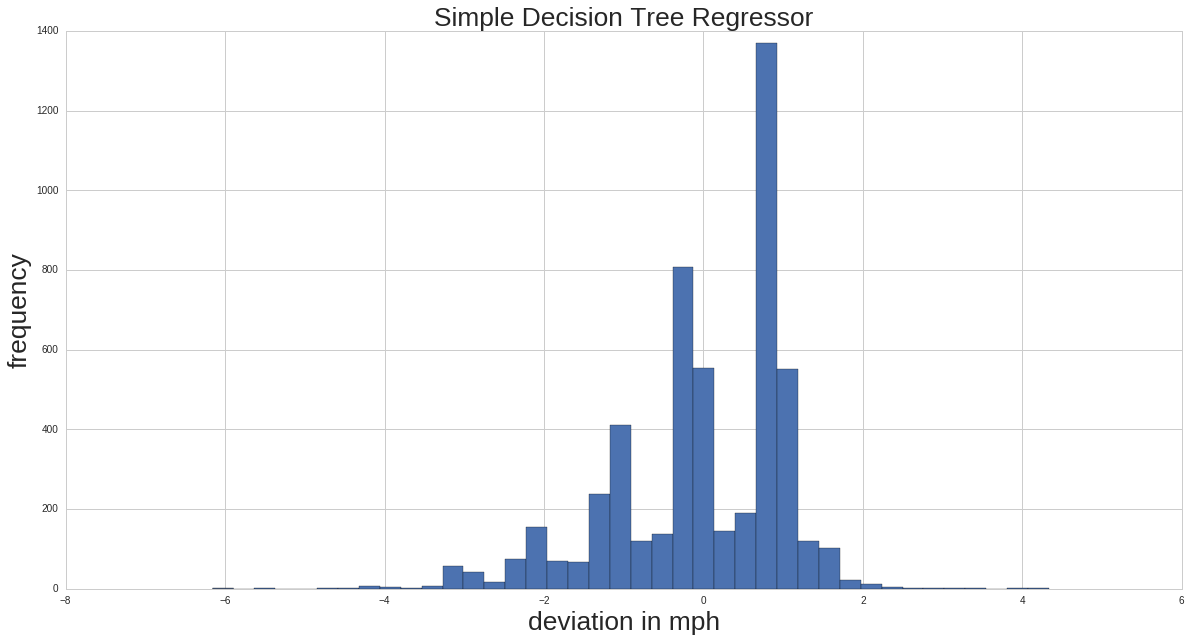

In [339]:
y_pred = regtree.predict(X_test)
np.linalg.norm(np.ceil(y_pred)-y_test)
diff = (y_pred-y_test)
# plt.figure(figsize=(12,10)) # not needed. set values globally
plt.hist(diff.values, bins=40)
print('Perzentile(%): ', [1,5,10,15,25,50,75,90,95,99], '\n', np.percentile(diff.values, [1,5,10,15,25,50,75,90,95,99]))
print('Mean absolute velocity deviation (in 1k): ', (sum(abs(diff))/len(diff)))
plt.title('Simple Decision Tree Regressor')
plt.xlabel('deviation in mph')
plt.ylabel('frequency')

In [396]:
regtree.tree_.value

array([[[ 7.03688667]],

       [[ 7.4158897 ]],

       [[ 7.22987616]],

       ..., 
       [[ 6.86252046]],

       [[ 6.784     ]],

       [[ 7.21621622]]])

In [340]:
regtree.tree_.max_depth

10

Perzentile(%):  [1, 5, 10, 15, 25, 50, 75, 90, 95, 99] 
 [-3.07424555 -2.00431365 -1.34298042 -1.12955524 -0.47991674  0.15
  0.74946581  1.03405591  1.27899568  1.83260094]
Mean absolute velocity deviation (in 1k):  0.810661491638


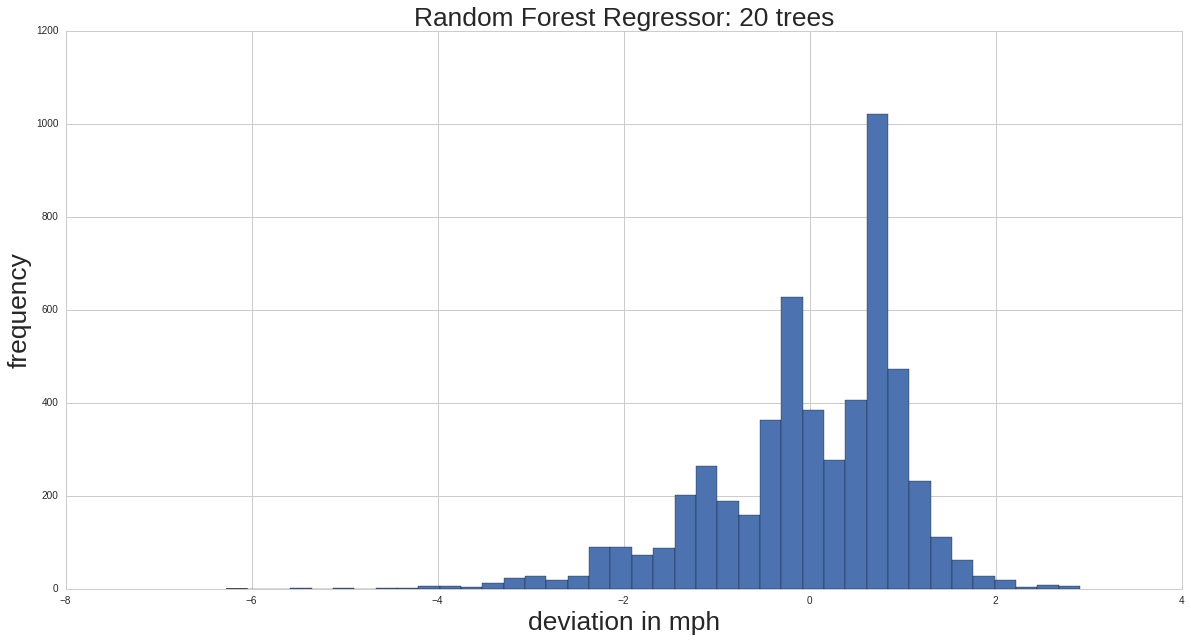

In [343]:
percentiles = [1,5,10,15,25,50,75,90,95,99]
y_pred = rd_regtree.predict(X_test)
np.linalg.norm(y_pred-y_test)
diff = (y_pred-y_test)
#plt.figure(figsize=(12,10))
plt.hist(diff.values, bins=40)
print('Perzentile(%): ', percentiles , '\n', np.percentile(diff.values, percentiles))
print('Mean absolute velocity deviation (in 1k): ', (sum(abs(diff))/len(diff)))
plt.title('Random Forest Regressor: 20 trees')
plt.xlabel('deviation in mph')
plt.ylabel('frequency')

In [415]:
from sklearn.externals import joblib
joblib.dump(regtree, 'treelib/bike_regtree_depth_10_PY27.pkl', protocol=2) 

['treelib/bike_regtree_depth_10_PY27.pkl',
 'treelib/bike_regtree_depth_10_PY27.pkl_01.npy',
 'treelib/bike_regtree_depth_10_PY27.pkl_02.npy',
 'treelib/bike_regtree_depth_10_PY27.pkl_03.npy']

In [416]:
from sklearn.externals import joblib
joblib.dump(rd_regtree, 'randforlib/bike_regtree_12x_depth_17_PY27.pkl.pkl', protocol=2)

['randforlib/bike_regtree_12x_depth_17_PY27.pkl.pkl',
 'randforlib/bike_regtree_12x_depth_17_PY27.pkl.pkl_01.npy',
 'randforlib/bike_regtree_12x_depth_17_PY27.pkl.pkl_02.npy',
 'randforlib/bike_regtree_12x_depth_17_PY27.pkl.pkl_03.npy',
 'randforlib/bike_regtree_12x_depth_17_PY27.pkl.pkl_04.npy',
 'randforlib/bike_regtree_12x_depth_17_PY27.pkl.pkl_05.npy',
 'randforlib/bike_regtree_12x_depth_17_PY27.pkl.pkl_06.npy',
 'randforlib/bike_regtree_12x_depth_17_PY27.pkl.pkl_07.npy',
 'randforlib/bike_regtree_12x_depth_17_PY27.pkl.pkl_08.npy',
 'randforlib/bike_regtree_12x_depth_17_PY27.pkl.pkl_09.npy',
 'randforlib/bike_regtree_12x_depth_17_PY27.pkl.pkl_10.npy',
 'randforlib/bike_regtree_12x_depth_17_PY27.pkl.pkl_11.npy',
 'randforlib/bike_regtree_12x_depth_17_PY27.pkl.pkl_12.npy',
 'randforlib/bike_regtree_12x_depth_17_PY27.pkl.pkl_13.npy',
 'randforlib/bike_regtree_12x_depth_17_PY27.pkl.pkl_14.npy',
 'randforlib/bike_regtree_12x_depth_17_PY27.pkl.pkl_15.npy',
 'randforlib/bike_regtree_12x_d

In [417]:
! cd randforlib && zip bike_regtree_12x_depth_17.zip bike_regtree_12x_depth_17_PY27.pkl*

  adding: bike_regtree_12x_depth_17_PY27.pkl.pkl (deflated 68%)
  adding: bike_regtree_12x_depth_17_PY27.pkl.pkl_01.npy (deflated 19%)
  adding: bike_regtree_12x_depth_17_PY27.pkl.pkl_02.npy (deflated 81%)
  adding: bike_regtree_12x_depth_17_PY27.pkl.pkl_03.npy (deflated 71%)
  adding: bike_regtree_12x_depth_17_PY27.pkl.pkl_04.npy (deflated 19%)
  adding: bike_regtree_12x_depth_17_PY27.pkl.pkl_05.npy (deflated 81%)
  adding: bike_regtree_12x_depth_17_PY27.pkl.pkl_06.npy (deflated 71%)
  adding: bike_regtree_12x_depth_17_PY27.pkl.pkl_07.npy (deflated 19%)
  adding: bike_regtree_12x_depth_17_PY27.pkl.pkl_08.npy (deflated 81%)
  adding: bike_regtree_12x_depth_17_PY27.pkl.pkl_09.npy (deflated 71%)
  adding: bike_regtree_12x_depth_17_PY27.pkl.pkl_10.npy (deflated 19%)
  adding: bike_regtree_12x_depth_17_PY27.pkl.pkl_11.npy (deflated 81%)
  adding: bike_regtree_12x_depth_17_PY27.pkl.pkl_12.npy (deflated 71%)
  adding: bike_regtree_12x_depth_17_PY27.pkl.pkl_13.npy (deflated 19%)
  adding: bik

## Read as follows: Split # x results in the children_left[x] and children_right[x], etc. Means: go to the left, and then step by step to the right...

In [130]:
print('cleft: ' + str(regtree.tree_.children_left) + '\n\n', #array of left children
      'cright: ' + str(regtree.tree_.children_right) + '\n\n', #array of right children
    regtree.tree_.feature, '\n\n',#array of nodes splitting feature
    regtree.tree_.threshold, '\n\n', #array of nodes splitting points
    #regtree.tree_.value
     ) #array of nodes values

cleft: [   1    2    3 ..., 1605   -1   -1]

 cright: [ 894  507  254 ..., 1606   -1   -1]

 [ 4  6  5 ...,  5 -2 -2] 

 [-73.88609314 -73.87641144  40.71151733 ...,  40.83932495  -2.          -2.        ] 




numpy.ndarray(regtree.tree_.children_left #array of left children
regtree.tree_.children_right #array of right children
regtree.tree_.feature #array of nodes splitting feature
regtree.tree_.threshold #array of nodes splitting points
regtree.tree_.value #array of nodes values

## Finding leaves:

In [131]:
leaves = regtree.tree_.children_left*regtree.tree_.children_right
for idx, a in enumerate(leaves):
    if a==1:
        x=1# do nothing
    else:
        leaves[idx] = 0
print(leaves)

[0 0 0 ..., 0 1 1]


## Now we've found the leaves

In [132]:
regtree.tree_.compute_feature_importances()

array([ 0.00201552,  0.02067813,  0.05331978,  0.17284459,  0.30449187,
        0.13772981,  0.3089203 ])

# Seems that the first 3 features are quite irrelevant right now...

In [133]:
splits = regtree.tree_.threshold

[  7.5  10.5   5.5   5.5   7.5   9.5  20.5   9.5  17.5   6.5   7.5  17.5
  10.5   6.5  17.5   6.5   7.5   6.5  17.5   6.5   5.5   7.5   6.5   6.5
  17.5  10.5   7.5   7.5   7.5   6.5  19.5   6.5   6.5  17.5   7.5   6.5
   6.5   6.5  18.5  18.5   6.5  10.5   5.5   5.5   7.5  19.5  18.5   4.5
  11.5   6.5  17.5   6.5   9.5   7.5   8.5   9.5   0.5  19.   14.5   4.5
  17.5   9.5   6.5  17.5   2.5  20.5   6.5  18.5   3.5  14.5  20.5   4.5
  14.   20.    9.5   2.5  17.5  15.5  11.   13.5  12.5   8.5   2.    1.5
  10.5  16.5   6.5  14.5   4.5  14.5  11.5  17.5   4.5   7.5  17.5  10.5
   7.5  19.   17.   13.5   8.5  18.5  19.5  12.5   8.5  15.5  14.5  22.5
   7.5   3.5  13.5   4.5   1.5   9.5   6.5   3.5   6.5   3.5   8.5   6.5
   9.5   8.5   6.5   7.5   0.5   5.5   8.5  10.5  17.5   3.5  16.5  14.5
  11.5   3.5   2.5  11.5  18.5  10.5   4.5   6.5  19.5  22.5  19.5  15.5
  21.   13.5   7.5  13.5  13.5   6.5  14.5  17.5  12.5   5.   10.5   7.5
  10.5   3.5   4.5  18.5   7.5   4.5   5.5   3.   2

(array([ 10.,  21.,  36.,  27.,  22.,  18.,  12.,  20.,  19.,  10.]),
 array([  0.5,   2.7,   4.9,   7.1,   9.3,  11.5,  13.7,  15.9,  18.1,
         20.3,  22.5]),
 <a list of 10 Patch objects>)

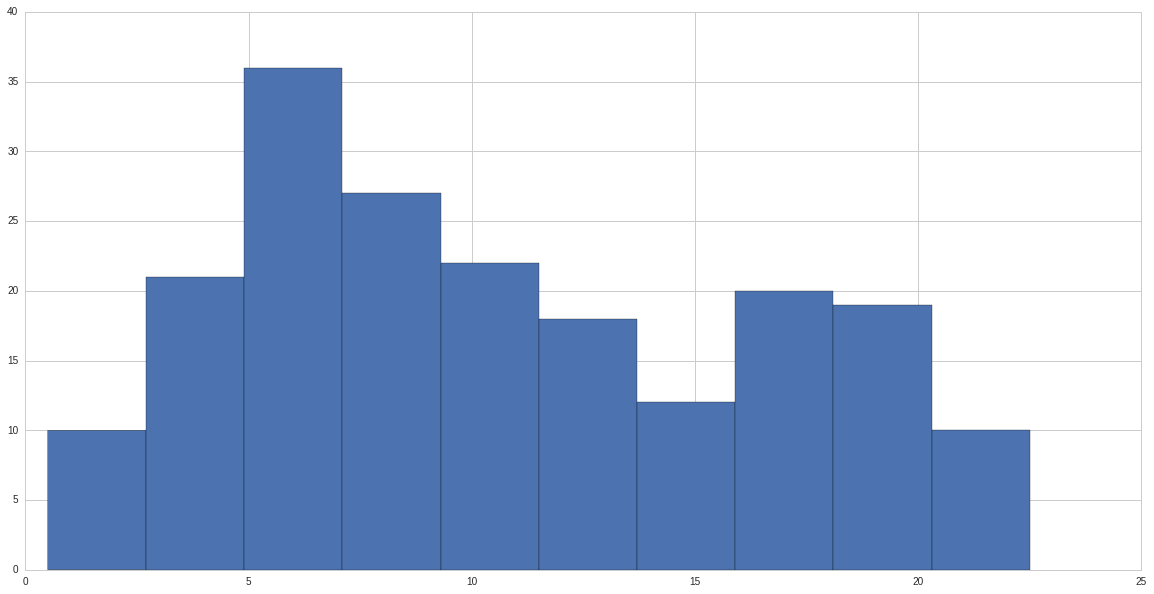

In [134]:
time_splits = splits[(splits>=0) & (splits<=24)]
print(time_splits)
plt.hist(time_splits)

# Where are splits in the hour?

# Filter the splits in longitudinal and latitudinal data

In [135]:
long_splits = splits[(splits>=-75) & (splits<=-70)]
lat_splits = splits[(splits>=40) & (splits<=41)]

# <font color = 'red'> The MSE of each node is stored in the 'impurity'-property. </font color>

In [136]:
#np.multiply(regtree.tree_.value, 1/ regtree.tree_.n_node_samples).size
avg_time_dev = regtree.tree_.impurity.T  * leaves
#avg_time_dev = (np.array(regtree.tree_.value)/np.array(regtree.tree_.n_node_samples)) *np.array(leaves)
avg_time_dev = avg_time_dev[avg_time_dev!=0]

In [137]:
avg_time_dev

array([  2.98089772e+01,   2.39769852e+01,   3.13388607e+01,
         2.25332896e+01,   2.22804048e+01,   2.99869810e+01,
         3.83369750e+01,   2.07098672e+01,   2.49863999e+01,
         3.77843762e+01,   3.68750000e+00,   1.60710059e+01,
         1.53722751e+01,   2.27125283e+01,   2.16740895e+01,
         1.81328277e+01,   2.32361592e+01,   2.88596873e+01,
         2.24318451e+01,   3.06682575e+01,   4.13069070e+01,
         4.40175256e+01,   2.16962707e+01,   5.83257618e+01,
         2.71539050e+01,   3.55195072e+01,   3.75072676e+01,
         3.25642177e+01,   2.99232070e+01,   2.76129658e+01,
         1.57879788e+01,   4.18594231e+01,   4.21534048e+01,
         2.20587055e+01,   3.48223561e+01,   3.56734211e+01,
         3.61657643e+01,   2.69355102e+01,   9.62162162e+01,
         6.51634349e+01,   2.21484900e+01,   2.22534582e+01,
         4.93639922e+01,   2.61742245e+01,   3.18070081e+01,
         5.54020911e+01,   1.63907765e+01,   1.34724911e+01,
         1.03401265e+01,

In [138]:
regtree.tree_.compute_feature_importances()

array([ 0.00201552,  0.02067813,  0.05331978,  0.17284459,  0.30449187,
        0.13772981,  0.3089203 ])

(array([  87.,   63.,  108.,   87.,   60.,   50.,   26.,   35.,   33.,
          20.,   16.,   13.,   13.,   13.,    4.,    3.,    7.,    2.,
           7.,    5.,    4.,    2.,    3.,    1.,    3.,    2.,    3.,
           1.,    1.,    2.,    3.,    1.,    2.,    2.,    0.,    1.,
           1.,    1.,    0.,    0.,    1.,    1.,    1.,    0.,    0.,
           0.,    0.,    1.,    1.,    0.]),
 array([   0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,
          90.,  100.,  110.,  120.,  130.,  140.,  150.,  160.,  170.,
         180.,  190.,  200.,  210.,  220.,  230.,  240.,  250.,  260.,
         270.,  280.,  290.,  300.,  310.,  320.,  330.,  340.,  350.,
         360.,  370.,  380.,  390.,  400.,  410.,  420.,  430.,  440.,
         450.,  460.,  470.,  480.,  490.,  500.]),
 <a list of 50 Patch objects>)

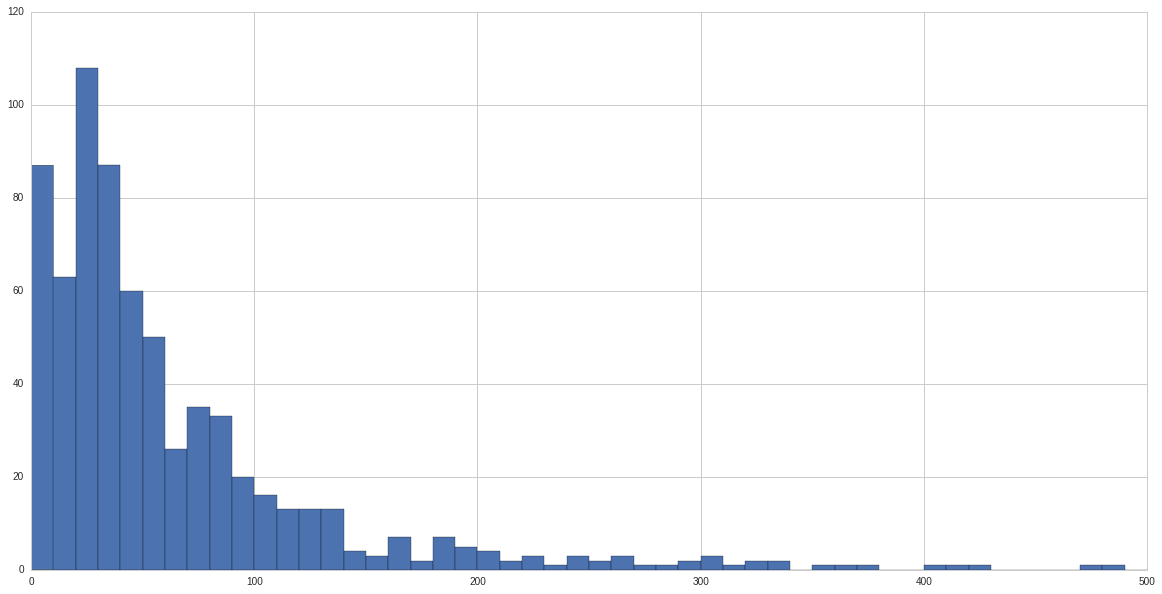

In [139]:
h = avg_time_dev
plt.hist(h.tolist(), bins=50, range=[0, 500])

In [140]:
np.percentile(avg_time_dev, q=[5, 50, 75, 90, 95, 97.5, 99])

array([   2.25      ,   40.40453686,   80.65816075,  144.65208316,
        233.20489438,  328.16237289,  488.59704894])

In [142]:
time_regression_df.columns[0:7]

Index(['pickup_datetime_day', 'pickup_datetime_dayofweek',
       'pickup_datetime_hour', 'pickup_latitude', 'pickup_longitude',
       'dropoff_latitude', 'dropoff_longitude'],
      dtype='object')

# <font color = 'blue'> Now we want to visualize the decision tree. To do so, plot the splits in geodata on the map of NYC (together with the heat map) </font color>

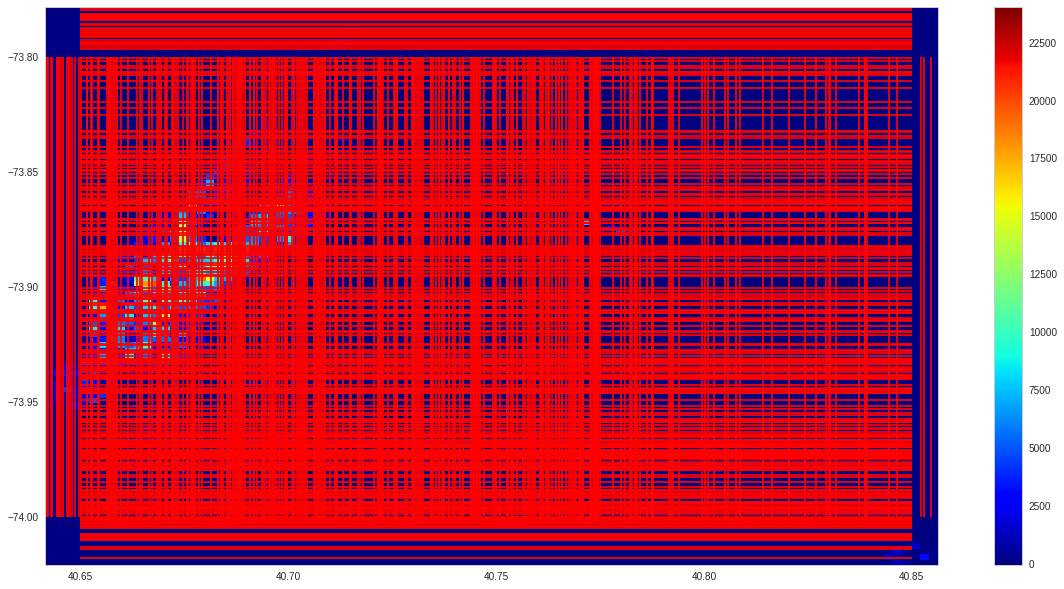

In [143]:
x = data_in_box.pickup_latitude
y = data_in_box.pickup_longitude

H, xedges, yedges = np.histogram2d(x, y, bins=100, normed=False, weights=None)

plt.jet()
fig = plt.figure(figsize=(20, 10))
#ax.set_title('pcolormesh: exact bin edges')
X, Y = np.meshgrid(xedges, yedges)
mesh = plt.pcolormesh(X, Y, H)
plt.colorbar(mesh)
#ax.set_aspect('equal')
#plt.savefig('figure.pdf', format='pdf')
#plt.savefig('figure.png', format='png')

## Plot the horizontal / vertival lines here via eventplot
plt.hold(True)
plt.eventplot(lat_splits, orientation='horizontal', lineoffsets=-73.9,
          linelengths=0.2, linewidths=None, color = [[1,0,0]],
          linestyles='solid')
plt.eventplot(long_splits, orientation='vertical', lineoffsets=40.75,
          linelengths=.2, linewidths=None, color = [[1,0,0]],
          linestyles='solid')
plt.axis([xedges.min(),xedges.max(),yedges.min(),yedges.max()]) # zoom in
plt.hold(False)